<a href="https://colab.research.google.com/github/YoheiFukuhara/recommender-system/blob/main/07_mf2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from datetime import datetime
import pickle

from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
BASE_PATH = '/content/drive/MyDrive/ColabNotebooks/ML/Recommend/output/'

In [3]:
def load_pickle(file):
    with open(BASE_PATH+file+'.pickle', 'rb') as f:
        return pickle.load(f)

user2movie = load_pickle('user2movie')
movie2user = load_pickle('movie2user')
usermovie2rating = load_pickle('usermovie2rating')
usermovie2rating_test = load_pickle('usermovie2rating_test')

In [4]:
N = np.max(list(user2movie.keys())) + 1
m1 = np.max(list(movie2user.keys()))
m2 = np.max([m for (u, m), r in usermovie2rating_test.items()])
M = max(m1, m2) + 1
print('N:', N, 'M:', M)  #if N is more than 10000, it takes so much time to process.

N: 4000 M: 1000


In [6]:
# convert user2movie and movie2user to include ratings
print("converting...")

# {user: [(movie, rating), ...]}
user2movierating = {}
for i, movies in user2movie.items():
    r = np.array([usermovie2rating[(i,j)] for j in movies])
    user2movierating[i] = (movies, r)

# {movie: [(user, rating),...]}
movie2userrating = {}
for j, users in movie2user.items():
    r = np.array([usermovie2rating[(i,j)] for i in users])
    movie2userrating[j] = (users, r)

# create a movie2user for test set, since we need it for loss
# {movie: [[user, ...], [rating, ..]],]}
movie2userrating_test = {}
for (i, j), r in usermovie2rating_test.items():
    if j not in movie2userrating_test:
        movie2userrating_test[j] = [[i], [r]]
    else:
        movie2userrating_test[j][0].append(i)
        movie2userrating_test[j][1].append(r)

for j, (users, r) in movie2userrating_test.items():
    movie2userrating_test[j][1] = np.array(r) # rating を配列からnumpy arrayに変換
print("conversion done")

converting...
conversion done


In [22]:
K = 10 # dimension
W = np.random.randn(N, K)
b = np.zeros(N)
U = np.random.randn(M, K)
c = np.zeros(M)
mu = np.mean(list(usermovie2rating.values()))

In [25]:
def get_loss(m2u):
    # d: movie_id -> (user_ids, ratings)
    N = 0.
    sse = 0
    for j, (u_ids, r) in m2u.items():  # 複数のu_idsとr
        pred = W[u_ids].dot(U[j]) + b[u_ids] + c[j] + mu
        delta = pred - r
        sse += delta.dot(delta)  # ドット積でsseはScalar 
        N += len(r)
    # print(f'delta: {delta}, sse: {sse}, len(r):, {len(r)}')
    return sse / N

In [26]:
%%time
# train the parameters
epochs = 12  # change from original 25
reg =20. # regularization penalty
train_losses = []
test_losses = []

for epoch in range(epochs):
    print(f"epoch:{epoch}")
    
    # perform updates
    epoch_start = datetime.now()

    # update W and b
    t0 = datetime.now()
    for i in range(N):

        # 前はjで個別計算していた部分をm_idsで一括計算
        m_ids, r = user2movierating[i]
        matrix = U[m_ids].T.dot(U[m_ids]) + np.eye(K) * reg  # np.eyeは単位行列(ここではK*K)
        vector = (r - b[i] - c[m_ids] - mu).dot(U[m_ids])
        bi = (r - U[m_ids].dot(W[i]) - c[m_ids] - mu).sum()        
        
        # set the updates
        W[i] = np.linalg.solve(matrix, vector)
        b[i] = bi / (len(user2movie[i]) + reg)

        if i % (N//3) == 0:
            print("i:", i, "N:", N)
    print("updated W and b:", datetime.now() - t0)

    # update U and c
    t0 = datetime.now()
    for j in range(M):
        try:
            
            # 前はiで個別計算していた部分をu_idsで一括計算
            u_ids, r = movie2userrating[j]
            matrix = W[u_ids].T.dot(W[u_ids]) + np.eye(K) * reg
            vector = (r - b[u_ids] - c[j] - mu).dot(W[u_ids])
            cj = (r - W[u_ids].dot(U[j]) - b[u_ids] - mu).sum()

            # set the updates
            U[j] = np.linalg.solve(matrix, vector)
            c[j] = cj / (len(movie2user[j]) + reg)

            if j % (M//3) == 0:
              print("j:", j, "M:", M)
        except KeyError:
          # possible not to have any ratings for a movie
            pass        

        except KeyError:
            # possible not to have any ratings for a movie
            pass
    print("updated U and c:", datetime.now() - t0)
    print("epoch duration:", datetime.now() - epoch_start)


    # store train loss
    t0 = datetime.now()
    train_losses.append(get_loss(movie2userrating))

    # store test loss
    test_losses.append(get_loss(movie2userrating_test))
    print("calculate cost:", datetime.now() - t0)
    print("train loss:", train_losses[-1])
    print("test loss:", test_losses[-1])

epoch:0
i: 0 N: 4000
i: 1333 N: 4000
i: 2666 N: 4000
i: 3999 N: 4000
updated W and b: 0:00:22.924465
j: 0 M: 1000
j: 333 M: 1000
j: 666 M: 1000
j: 999 M: 1000
updated U and c: 0:00:26.167304
epoch duration: 0:00:49.091904
calculate cost: 0:00:12.780291
train loss: 0.5021547041778659
test loss: 0.5373306667658683
epoch:1
i: 0 N: 4000
i: 1333 N: 4000
i: 2666 N: 4000
i: 3999 N: 4000
updated W and b: 0:00:30.013998
j: 0 M: 1000
j: 333 M: 1000
j: 666 M: 1000
j: 999 M: 1000
updated U and c: 0:00:26.991974
epoch duration: 0:00:57.006107
calculate cost: 0:00:12.707201
train loss: 0.500876772412561
test loss: 0.5358368130154038
epoch:2
i: 0 N: 4000
i: 1333 N: 4000
i: 2666 N: 4000
i: 3999 N: 4000
updated W and b: 0:00:23.214901
j: 0 M: 1000
j: 333 M: 1000
j: 666 M: 1000
j: 999 M: 1000
updated U and c: 0:00:32.818014
epoch duration: 0:00:56.033057
calculate cost: 0:00:12.413192
train loss: 0.5002228926649958
test loss: 0.5350689042729548
epoch:3
i: 0 N: 4000
i: 1333 N: 4000
i: 2666 N: 4000
i: 399

train losses: [0.5021547041778659, 0.500876772412561, 0.5002228926649958, 0.4998471371017766, 0.4996207860496339, 0.4994768632632861, 0.49938333736740415, 0.4993205403680162, 0.4992779559347775, 0.4992483662635308, 0.49922769332859074, 0.49921294553323087]
test losses: [0.5373306667658683, 0.5358368130154038, 0.5350689042729548, 0.534620234020212, 0.5343517789320538, 0.5341801382433493, 0.5340719111909874, 0.5340007835297926, 0.5339555396585981, 0.5339258498485934, 0.5339072489534709, 0.5338953554465222]


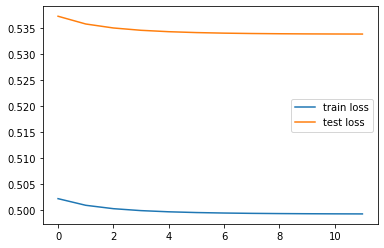

In [27]:
print("train losses:", train_losses)
print("test losses:", test_losses)

# plot losses
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.legend()
plt.show()